In [1]:
import torchvision.transforms.functional as TF
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
    
print("Import Completed")

import sys
sys.path.append("..")
# from latexify import latexify, format_axes

!wget https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg -O iitgn.jpg


Device:  cuda
Import Completed
--2024-09-16 18:38:30--  https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg
Resolving news.iitgn.ac.in (news.iitgn.ac.in)... 192.185.129.4
Connecting to news.iitgn.ac.in (news.iitgn.ac.in)|192.185.129.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238762 (233K) [image/jpeg]
Saving to: 'iitgn.jpg'

iitgn.jpg           100%[===================>] 233.17K  1.18MB/s    in 0.2s    

2024-09-16 18:38:31 (1.18 MB/s) - 'iitgn.jpg' saved [238762/238762]



In [2]:
# Set the random seed for reproducibility
torch.manual_seed(42)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")

Using 2 GPUs


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

torch.Size([3, 600, 900])


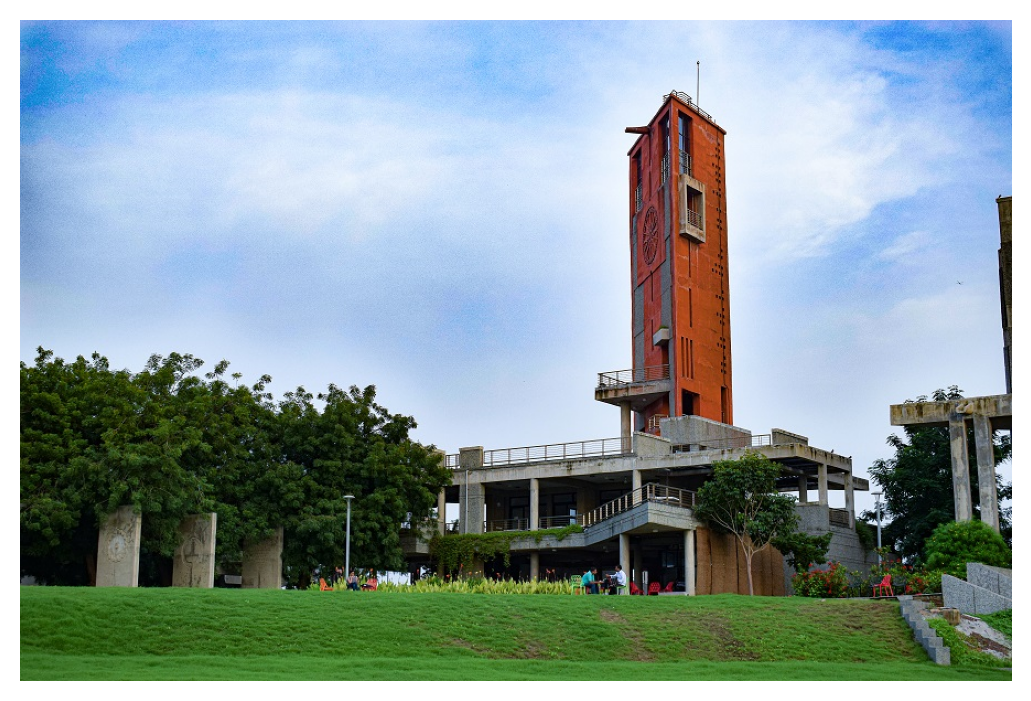

In [4]:
# Read in a image from torchvision
img = torchvision.io.read_image("iitgn.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.axis('off')
plt.show()

In [5]:
from sklearn import preprocessing
# scaling the image tensor
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
# apply the fitted scalar to the reshaped image  , and then reshape back to the original dimensions
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)
img_scaled = torch.tensor(img_scaled)

(3, 600, 900)


In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.5412, 0.5333, 0.4863,  ..., 0.5451, 0.5608, 0.5412],
         [0.5059, 0.5373, 0.5059,  ..., 0.5647, 0.5451, 0.5451],
         [0.5412, 0.5333, 0.5098,  ..., 0.5647, 0.5216, 0.5373],
         ...,
         [0.2627, 0.2941, 0.2549,  ..., 0.2314, 0.2157, 0.1843],
         [0.1647, 0.1647, 0.1882,  ..., 0.2314, 0.2196, 0.2078],
         [0.2039, 0.2275, 0.2588,  ..., 0.2157, 0.2039, 0.2157]],

        [[0.6902, 0.6902, 0.6667,  ..., 0.6667, 0.6824, 0.6627],
         [0.6549, 0.6941, 0.6667,  ..., 0.6863, 0.6667, 0.6667],
         [0.6784, 0.6706, 0.6471,  ..., 0.6863, 0.6431, 0.6588],
         ...,
         [0.4667, 0.4980, 0.4588,  ..., 0.4157, 0.4000, 0.3686],
         [0.3647, 0.3647, 0.3882,  ..., 0.4157, 0.4039, 0.3922],
         [0.4039, 0.4275, 0.4588,  ..., 0.4000, 0.3882, 0.4000]],

        [[0.9333, 0.9294, 0.9020,  ..., 0.9294, 0.9451, 0.9255],
         [0.8980, 0.9333, 0.9098,  ..., 0.9490, 0.9294, 0.9294],
         [0.9294, 0.9216, 0.9059,  ..., 0.9412, 0.8980, 0.

In [8]:
# Functional Crop
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 150, 300, 400, 400)
print(crop.shape)


original_image = crop
del crop

# # Load original high-resolution image (assuming it's 400x400)
low_res_img = TF.resize(original_image, [200, 200])  # Resize to 200x200
print(low_res_img.shape)



torch.Size([3, 400, 400])
torch.Size([3, 200, 200])


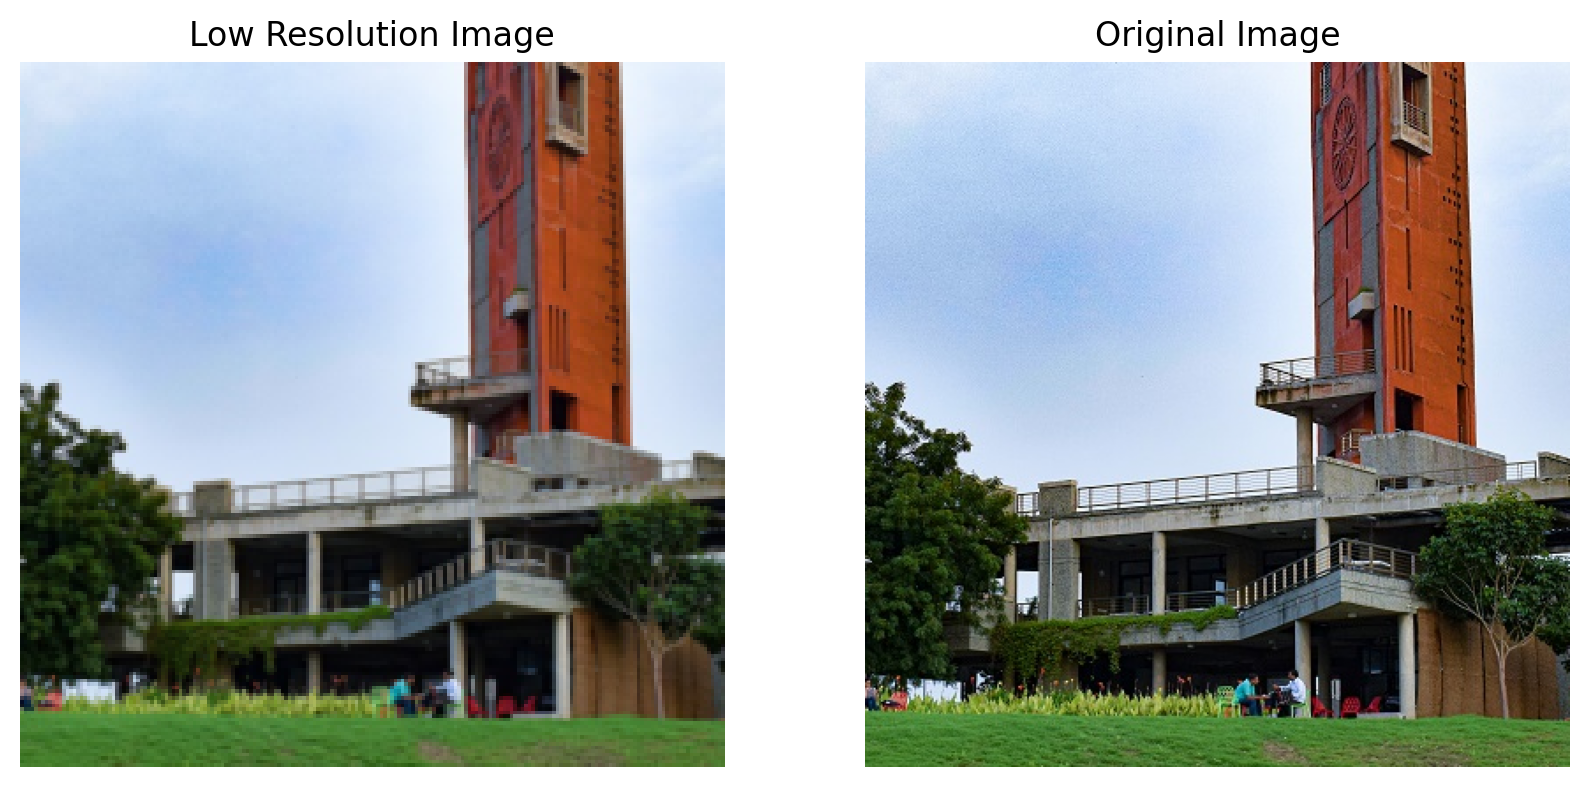

In [9]:
# compare both the images low res img and original image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(rearrange(low_res_img, 'c h w -> h w c').cpu().numpy())
ax[0].set_title("Low Resolution Image")
ax[0].axis('off')

ax[1].imshow(rearrange(original_image, 'c h w -> h w c').cpu().numpy())
ax[1].set_title("Original Image")
ax[1].axis('off')
plt.show()

In [10]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    print("Number of channels:", num_channels, "\nHeight:", height, "\nWidth:", width)
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    print("-"*50)
    
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    print("X shape:", X.shape)
    
    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    print("Y shape:", Y.shape)

    return X, Y

In [11]:
import torch
import sklearn.preprocessing as preprocessing


low_res_X, low_res_Y = create_coordinate_map(low_res_img)
high_res_X, _ = create_coordinate_map(original_image)  # Only need the coordinates for high-res

print(low_res_X.shape, low_res_Y.shape)
print(low_res_X , low_res_Y)
print(high_res_X.shape)
print(high_res_X)

# Scale low-res coordinates
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(low_res_X.cpu())
low_res_X_scaled = scaler_X.transform(low_res_X.cpu())
high_res_X_scaled = scaler_X.transform(high_res_X.cpu())  # Scale high-res coordinates

low_res_X_scaled = torch.tensor(low_res_X_scaled).float().to(device)
high_res_X_scaled = torch.tensor(high_res_X_scaled).float().to(device)


Number of channels: 3 
Height: 200 
Width: 200
--------------------------------------------------
X shape: torch.Size([40000, 2])
Y shape: torch.Size([40000, 3])
Number of channels: 3 
Height: 400 
Width: 400
--------------------------------------------------
X shape: torch.Size([160000, 2])
Y shape: torch.Size([160000, 3])
torch.Size([40000, 2]) torch.Size([40000, 3])
tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]], device='cuda:0') tensor([[0.8915, 0.9385, 0.9858],
        [0.8885, 0.9356, 0.9859],
        [0.8866, 0.9338, 0.9928],
        ...,
        [0.3035, 0.4805, 0.1931],
        [0.3162, 0.5052, 0.2038],
        [0.2981, 0.4837, 0.1761]])
torch.Size([160000, 2])
tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [399., 397.],
        [399., 398.],
        [399., 399.]], device='cuda:0')


In [12]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [13]:
X_rff_low_res = create_rff_features(low_res_X_scaled, num_features=20000, sigma=0.008)
print("X_rff_low_res shape:", X_rff_low_res.shape)
print(X_rff_low_res)

X_rff_low_res shape: torch.Size([40000, 20000])
tensor([[ 0.0086, -0.0078, -0.0035,  ..., -0.0091,  0.0100,  0.0030],
        [ 0.0098, -0.0038, -0.0008,  ..., -0.0073,  0.0098, -0.0033],
        [ 0.0064,  0.0011,  0.0050,  ..., -0.0048,  0.0096, -0.0083],
        ...,
        [-0.0036, -0.0019,  0.0080,  ...,  0.0053, -0.0048, -0.0023],
        [ 0.0033, -0.0064, -0.0047,  ...,  0.0077, -0.0038,  0.0040],
        [ 0.0087, -0.0093,  0.0005,  ...,  0.0093, -0.0027,  0.0087]],
       device='cuda:0')


In [14]:
# linear Regression - neural  network with one input and output layer - no hidden layers
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        # Define a linear transformation
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

In [15]:

# update the train function to exit if loss is not decreasing

def train(net, lr, X, Y, epochs, verbose=True):

    losses = []
    count =0
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(1,epochs+1):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

        if epoch > 1 and losses[-2] < losses[-1]:
            count+=1
            if count>3:
                print("Loss is not decreasing. Exiting...")
                break
    return loss.item(),losses

In [16]:
torch.cuda.empty_cache()

In [17]:
# Initialize and train the model
model = LinearModel(X_rff_low_res.shape[1], 3)  # 3 for RGB channels
model.to(device)
print(model)
# Ensure low_res_Y is on the same device as X
low_res_Y = low_res_Y.to(device)


# Train the model with the low-res coordinates and pixel values
train_loss,training_losses = train(model, lr=0.005, X=X_rff_low_res, Y=low_res_Y, epochs=5000)
print(f"Final training loss: {train_loss:.6f}")
# train_loss,training_losses = train(net, 0.01, dog_X_scaled, dog_Y, 1000)
del low_res_Y , X_rff_low_res
torch.cuda.empty_cache()
import gc
gc.collect()

LinearModel(
  (linear): Linear(in_features=20000, out_features=3, bias=True)
)
Epoch 100 loss: 0.091417
Epoch 200 loss: 0.059245
Epoch 300 loss: 0.047804
Epoch 400 loss: 0.039263
Epoch 500 loss: 0.032472
Epoch 600 loss: 0.026942
Epoch 700 loss: 0.022374
Epoch 800 loss: 0.018568
Epoch 900 loss: 0.015383
Epoch 1000 loss: 0.012714
Epoch 1100 loss: 0.010480
Epoch 1200 loss: 0.008616
Epoch 1300 loss: 0.007067
Epoch 1400 loss: 0.005786
Epoch 1500 loss: 0.004733
Epoch 1600 loss: 0.003873
Epoch 1700 loss: 0.003174
Epoch 1800 loss: 0.002611
Epoch 1900 loss: 0.002159
Epoch 2000 loss: 0.001799
Epoch 2100 loss: 0.001515
Epoch 2200 loss: 0.001290
Epoch 2300 loss: 0.001115
Epoch 2400 loss: 0.000978
Epoch 2500 loss: 0.000872
Epoch 2600 loss: 0.000790
Epoch 2700 loss: 0.000727
Epoch 2800 loss: 0.000678
Epoch 2900 loss: 0.000640
Epoch 3000 loss: 0.000611
Epoch 3100 loss: 0.000588
Epoch 3200 loss: 0.000571
Epoch 3300 loss: 0.000557
Epoch 3400 loss: 0.000545
Epoch 3500 loss: 0.000536
Epoch 3600 loss: 0.

2168

In [18]:
# Now use the learned model to predict for high-resolution coordinates
X_rff_high_res = create_rff_features(high_res_X_scaled, num_features=20000, sigma=0.008)
print("X_rff_high_res shape:", X_rff_high_res.shape)
print(X_rff_high_res)

X_rff_high_res shape: torch.Size([160000, 20000])
tensor([[-5.6075e-03, -7.0821e-03, -3.8495e-03,  ...,  8.5272e-03,
         -7.7360e-03,  9.2480e-03],
        [ 1.0221e-03, -3.1939e-03, -1.9482e-03,  ..., -5.2102e-03,
         -9.1950e-03, -4.0945e-03],
        [ 3.8066e-03,  1.3637e-03,  3.0097e-05,  ...,  7.4876e-04,
         -9.9261e-03, -3.3046e-03],
        ...,
        [ 2.8923e-03,  7.1923e-03,  1.6148e-03,  ..., -8.0501e-03,
          7.9371e-04, -9.7711e-03],
        [ 1.9814e-03,  3.3425e-03, -3.6903e-04,  ...,  4.4630e-03,
         -2.0147e-03,  8.5549e-03],
        [-6.3834e-03, -1.2078e-03, -2.3382e-03,  ...,  1.0510e-04,
         -4.6637e-03, -2.6467e-03]], device='cuda:0')


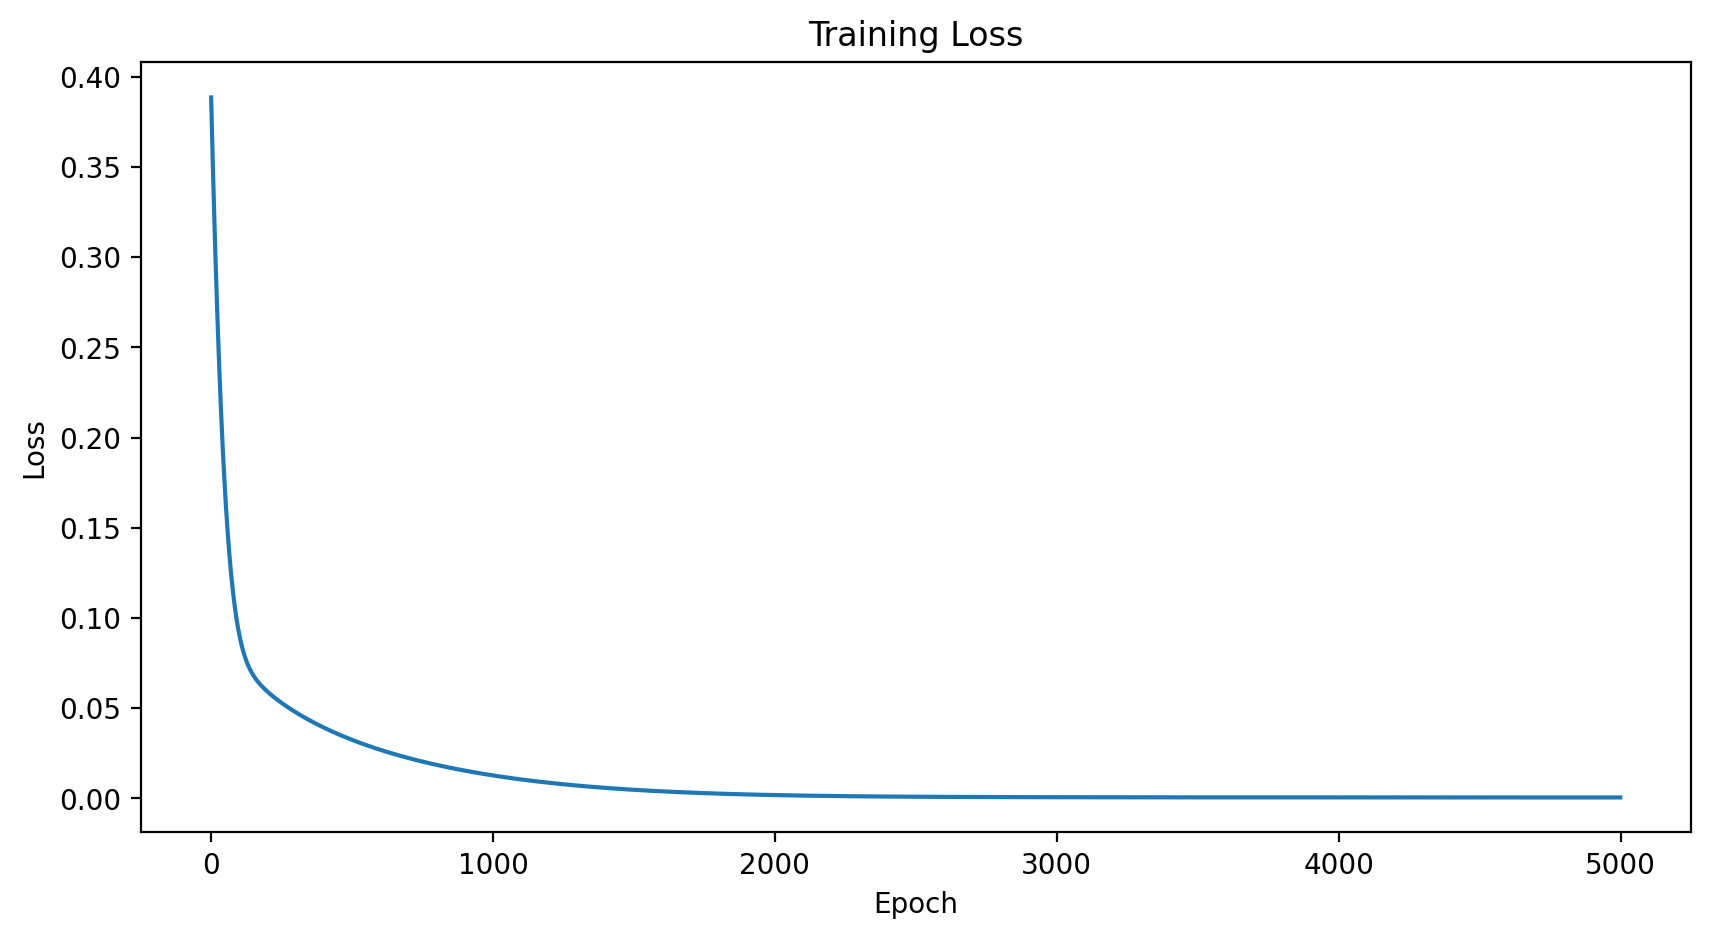

In [19]:
torch.cuda.empty_cache()

# plot training loss graph
plt.figure(figsize=(10, 5))
# latexify()
# format_axes(plt.gca())
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [20]:

model.eval()
with torch.no_grad():
    high_res_pred_Y = model(X_rff_high_res)
    high_res_pred_Y = high_res_pred_Y.reshape(400, 400, 3).cpu().numpy()
    high_res_pred_Y = np.clip(high_res_pred_Y, 0, 1)  # Clip values to [0, 1]

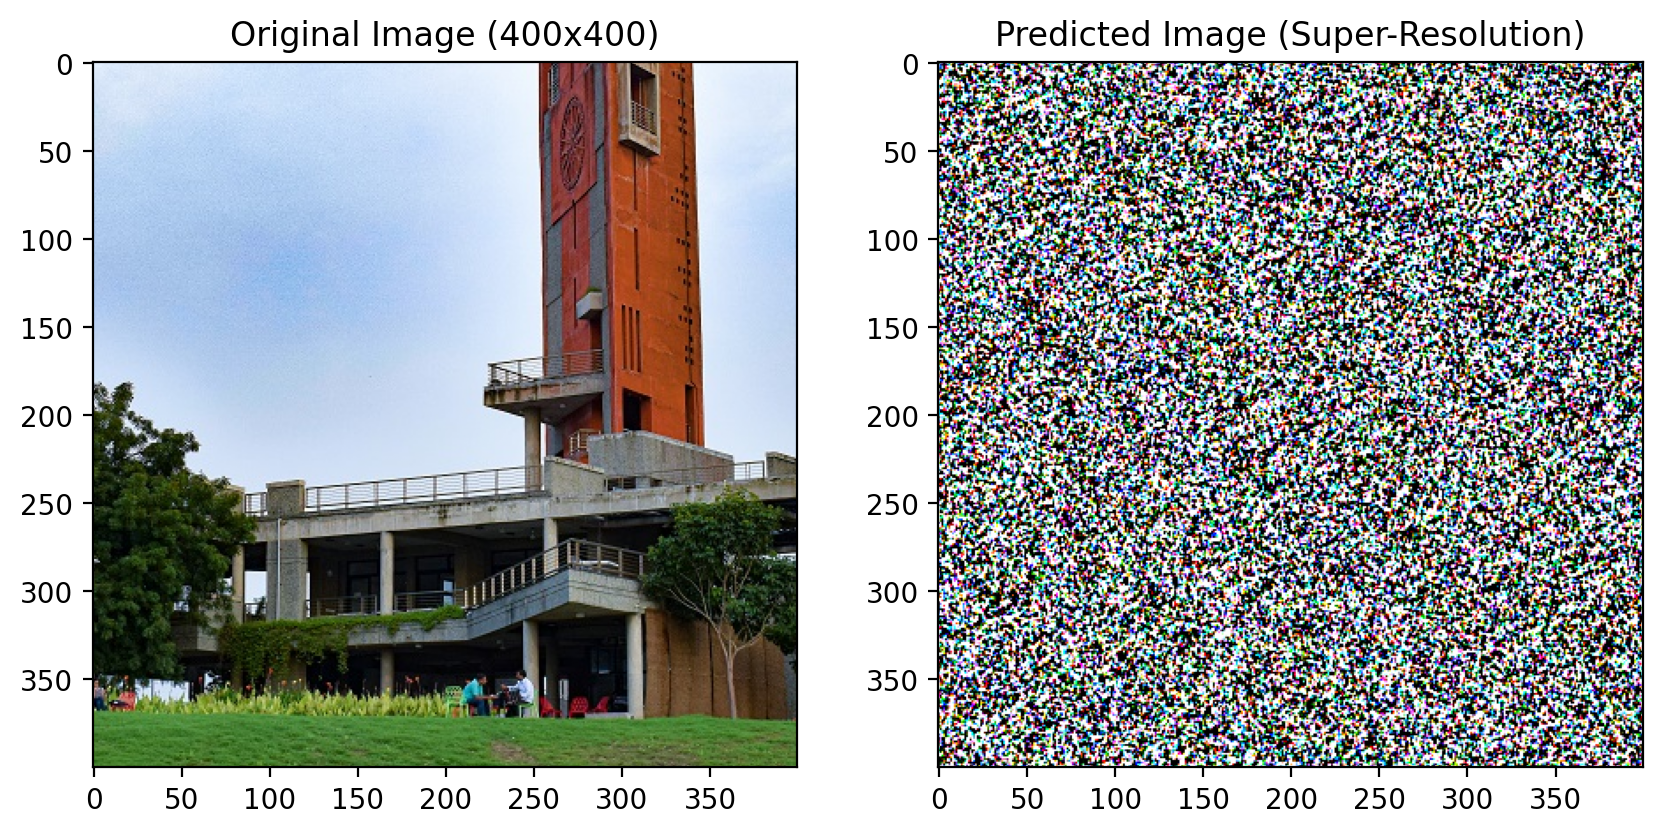

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(rearrange(original_image.cpu(), 'c h w -> h w c').numpy())
ax1.set_title('Original Image (400x400)')

ax2.imshow(high_res_pred_Y)
ax2.set_title('Predicted Image (Super-Resolution)')

plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Compute RMSE
rmse = mean_squared_error(rearrange(original_image.cpu(), 'c h w -> h w c').numpy().ravel(), high_res_pred_Y.ravel(), squared=False)

# Compute PSNR
def compute_psnr(true_img, pred_img, max_val=1.0):
    mse = mean_squared_error(true_img, pred_img)
    psnr = 20 * math.log10(max_val) - 10 * math.log10(mse)
    return psnr

psnr = compute_psnr(rearrange(original_image.cpu(), 'c h w -> h w c').numpy(), high_res_pred_Y)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")
